In [67]:
import numpy as np
np.random.seed(7)

class PCA:
    def __init__(self, n_components=2):
        self.n_components = n_components

    def fit(self, data):
        self.data = data
        self.mean = np.mean(data, axis=0)
        self.std = np.std(data, axis=0)
        data = (data - self.mean) / self.std
        U, S, V = np.linalg.svd(data, full_matrices=False)
        self.components = V.T[:, :self.n_components]

    def transform(self, data):
        data = (data - self.mean) / self.std
        return np.dot(data, self.components)

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [68]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Ellipse

class GaussianMixture:
    def __init__(self, n_components=1, tol=1e-5):
        """
        Parameters:
        -----------
        n_components (int): The number of mixture components.
        max_iter (int): The maximum number of iterations to perform.
        tol (float): The convergence threshold.
        """
        self.n_components = n_components
        self.tol = tol

    def _initialize_parameters(self, data: np.array) -> None:
        """
        Initialize the model parameters.

        Parameters:
        -----------
        data (np.array): The data to fit the model to.
        """
        # Initialize the weights
        self.weights = np.ones(self.n_components) / self.n_components

        # Initialize the means by sampling from the data
        random_rows = np.random.choice(data.shape[0], self.n_components)
        self.means = data[random_rows]

        # Initialize the covariance matrices as identity
        self.covs = np.array([np.eye(data.shape[1])] * self.n_components)

        # Initialize the log likelihood
        self.log_likelihood = 0.

    def _multivariate_gaussian(self, data: np.array, mu: np.array, cov: np.array) -> np.array:
        """
        Compute the multivariate Gaussian distribution.

        Parameters:
        -----------
        data (np.array): The data to fit the model to.
        mu (np.array): The mean vector.
        cov (np.array): The covariance matrix.

        Returns:
        --------
        np.array: The probability density.
        """
        # Compute the determinant and inverse of the covariance matrix
        det = np.linalg.det(cov)
        inv = np.linalg.inv(cov)

        # Compute the exponent
        exp = np.exp(-0.5 * np.sum((data - mu) @ inv * (data - mu), axis=1))

        # Compute the multivariate Gaussian
        return 1. / np.sqrt((2 * np.pi) ** data.shape[1] * det) * exp
    
    def _likelihoods(self, data: np.array) -> np.array:
        """
        Compute the likelihoods of the data.

        Parameters:
        -----------
        data (np.array): The data to fit the model to.

        Returns:
        --------
        np.array: The likelihoods.
        """
        # Compute the likelihoods of each component given the data
        return np.array([self._multivariate_gaussian(data, mu, cov) for mu, cov in zip(self.means, self.covs)])
    
    def _log_likelihood(self, data: np.array) -> float:
        """
        Compute the log likelihood of the data.

        Parameters:
        -----------
        data (np.array): The data to fit the model to.

        Returns:
        --------
        float: The log likelihood.
        """
        # Compute the likelihoods of each component given the data
        likelihoods = self._likelihoods(data)
        weighted_likelihoods = likelihoods * self.weights[:, np.newaxis]

        # Compute the log likelihood
        return np.log(weighted_likelihoods.sum(axis=0)).sum()

    def _expectation(self, data: np.array) -> None:
        """
        The expectation step of the EM algorithm.

        Parameters:
        -----------
        data (np.array): The data to fit the model to.
        """
        # Compute the likelihoods of each component given the data
        likelihoods = self._likelihoods(data)

        # Compute the responsibilities
        numerator = likelihoods * self.weights[:, np.newaxis]
        denominator = numerator.sum(axis=0)
        self.responsibilities = numerator / denominator

    def _maximization(self, data: np.array) -> None:
        """
        The maximization step of the EM algorithm.

        Parameters:
        -----------
        data (np.array): The data to fit the model to.
        """
        # Compute the total responsibility for each component
        responsibilities = self.responsibilities.sum(axis=1)

        # Update the weights
        self.weights = responsibilities / data.shape[0]

        # Update the means
        weighted_sum = self.responsibilities @ data
        self.means = weighted_sum / responsibilities[:, np.newaxis]

        # Update the covariance matrices
        for i in range(self.n_components):
            diff = data - self.means[i]
            weighted_sum = self.responsibilities[i] * diff.T @ diff
            self.covs[i] = weighted_sum / responsibilities[i] + np.eye(data.shape[1]) * 1e-6

    def _converged(self, data: np.array) -> bool:
        """
        Check for convergence.

        Parameters:
        -----------
        data (np.array): The data to fit the model to.

        Returns:
        --------
        bool: Whether the model has converged.
        """
        new_log_likelihood = self._log_likelihood(data)

        previous_log_likelihood = self.log_likelihood
        self.log_likelihood = new_log_likelihood

        # Check for convergence
        if abs(new_log_likelihood - previous_log_likelihood) < self.tol:
            return True

        return False

    def fit(self, data: np.array) -> None:
        """
        Fit a Gaussian mixture model to the data.

        Parameters:
        -----------
        data (np.array): The data to fit the model to.
        """
        # Initialize the parameters
        self._initialize_parameters(data)

        self.history = [(self.means.copy(), self.covs.copy())]

        # Iterate until convergence or max iterations
        while True:
            # E-step
            self._expectation(data)

            # M-step
            self._maximization(data)

            # Store the current means and covs
            self.history.append((self.means.copy(), self.covs.copy()))

            # Check for convergence
            if self._converged(data):
                break
            
    def bic(self, data: np.array) -> float:
        """
        Compute the Bayesian Information Criterion (BIC) of the model.

        Parameters:
        -----------
        data (np.array): The data to fit the model to.

        Returns:
        --------
        float: The BIC.
        """
        n = data.shape[0]
        k = self.n_components * (1 + data.shape[1] + (data.shape[1] * (data.shape[1] + 1)) / 2)

        return np.log(n) * k - 2 * self._log_likelihood(data)
    
    def animate(self, data: np.array, frames: int = 40, save=False) -> None:
        """
        Show the convergence of the EM algorithm.

        Parameters:
        -----------
        data (np.array): The data to fit the model to.
        """
        fig, ax = plt.subplots()

        steps = np.linspace(0, len(self.history) - 1, frames, dtype=np.int32)

        # Generate a unique color for each Gaussian
        colors = plt.cm.rainbow(np.linspace(0, 1, len(self.means)))

        def update(i):
            ax.clear()
            ax.scatter(data[:, 0], data[:, 1], s=10, alpha=0.5)
            for mean, cov, color in zip(*self.history[steps[i]], colors):
                eigvals, eigvecs = np.linalg.eigh(cov)
                order = eigvals.argsort()[::-1]
                eigvals, eigvecs = eigvals[order], eigvecs[:, order]
                vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
                theta = np.arctan2(vy, vx)
                for j in range(1, 4):
                    ell = Ellipse(xy=(mean[0], mean[1]),
                                width=np.sqrt(eigvals[0])*j*2, height=np.sqrt(eigvals[1])*j*2,
                                angle=np.degrees(theta),
                                facecolor='none', edgecolor=color)
                    ax.add_artist(ell)
                
                # Plot the mean with a cross
                ax.scatter(mean[0], mean[1], marker='+', s=50, color='black', alpha=0.5)

                # set title to iteration number
                ax.set_title(f'Iteration {steps[i]}')

        ani = animation.FuncAnimation(fig, update, frames=frames, repeat=True)
        
        if save:
            ani.save(f'estimated-{self.n_components}-clusters.gif', writer='imagemagick')

        plt.show()

    def predict(self, data: np.array) -> np.array:
        """
        Predict the labels for the data.

        Parameters:
        -----------
        data (np.array): The data to fit the model to.

        Returns:
        --------
        np.array: The predicted labels.
        """
        # Compute the likelihoods of each component given the data
        likelihoods = self._likelihoods(data)
        
        # Return the index of the component with the largest likelihood
        return likelihoods.argmax(axis=0)

In [69]:
data = np.loadtxt('../datasets/2D_data_points_1.txt', delimiter=',')

data_2d = data
if data.shape[1] > 2:
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)

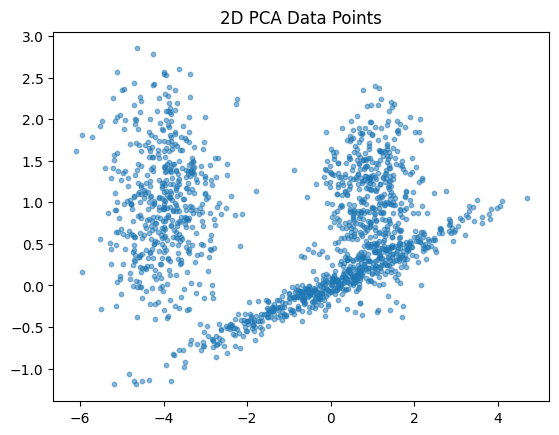

In [70]:
# plot the data with title
plt.scatter(data_2d[:, 0], data_2d[:, 1], s=10, alpha=0.5)
plt.title('2D PCA Data Points')
plt.savefig('pca.jpg')
plt.show()

In [71]:
from tqdm import tqdm

min_k = 3
max_k = 7

best_gmms = []
for k in tqdm(range(min_k, max_k + 1)):
    trials = 5
    best_gmm = None
    best_log_likelihood = -np.inf
    convergence_log_likelihoods = np.zeros(trials)

    for i in range(trials):
        gmm = GaussianMixture(n_components=k)
        gmm.fit(data_2d)

        if gmm.log_likelihood > best_log_likelihood:
            best_log_likelihood = gmm.log_likelihood
            best_gmm = gmm
    
    best_gmms.append(best_gmm)

100%|██████████| 5/5 [00:42<00:00,  8.53s/it]


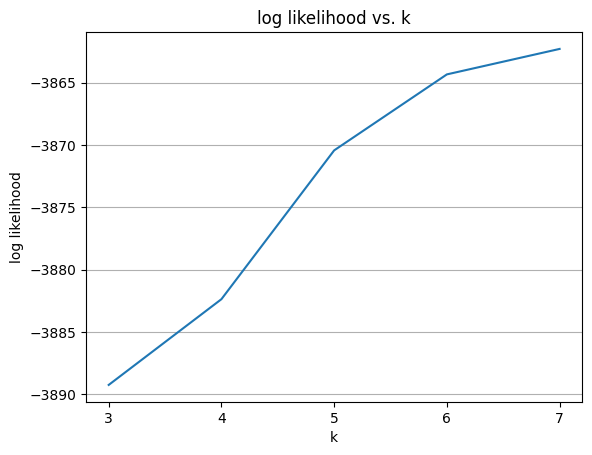

In [72]:
from matplotlib.ticker import MultipleLocator

# plot log likelihood vs. k
log_likelihoods = [best_gmm.log_likelihood for best_gmm in best_gmms]
plt.plot(range(min_k, max_k + 1), log_likelihoods)
plt.title('log likelihood vs. k')
plt.grid(axis='y')

plt.gca().yaxis.set_minor_locator(MultipleLocator(5))
plt.grid(axis='y', which='minor', alpha=0.2)
plt.xticks(range(min_k, max_k + 1))
plt.xlabel('k')
plt.ylabel('log likelihood')
plt.savefig('log-likelihoods.jpg')
plt.show()

Best GMM: 3 components


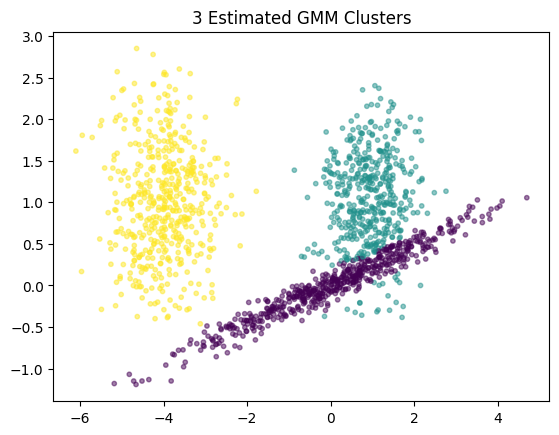

MovieWriter imagemagick unavailable; using Pillow instead.


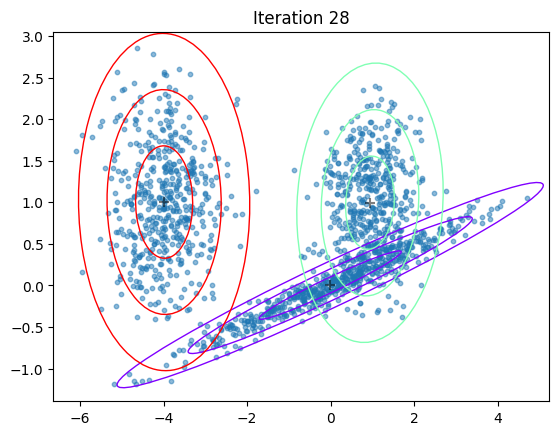

In [73]:
# use bic to choose the best model
bic = [best_gmm.bic(data_2d) for best_gmm in best_gmms]
best_gmm = best_gmms[np.argmin(bic)]

print(f'Best GMM: {best_gmm.n_components} components')

# plot the original data points colored by their cluster assignments
clusters = best_gmm.predict(data_2d)

plt.scatter(data_2d[:, 0], data_2d[:, 1], c=clusters, s=10, alpha=0.5)
plt.title(f'{best_gmm.n_components} Estimated GMM Clusters')
plt.savefig('estimated-gmm-clusters.jpg')
plt.show()

best_gmm.animate(data_2d, frames=60, save=True)